In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [3]:
from transformers import (
    GPT2Config,
    GPT2Tokenizer,
    GPT2LMHeadModel,
)

/home/cgagne/cvar_generation/conda_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
modelname = '../models/pretrained/gpt2-large/'
config = GPT2Config.from_pretrained(modelname)
tokenizer = GPT2Tokenizer.from_pretrained(modelname)

In [5]:
import sys
sys.path.append('../')
from rl_learner import TD_Learner
import torch
import pickle
device = 'cpu'
import sys
sys.path.append('../')

from cvar_helpers import calc_cvar_from_samples
from train_rl_batch_sentence_chains import average_states_by_period

## Creating Dataset V4: 

### Combine training data from V3

In [ ]:
# all_lines = []
# for filename in ['generations_using.txt','generations_seed1322.txt','generations_seed2131.txt',
#                  'generations_seed2311.txt', 'generations_seed3122.txt']:
    
#     with open('../data/results/sentence_chains_I_3/'+filename,'r') as file:
#         all_lines += file.readlines()

# all_lines = set(all_lines)

# with open('../data/results/sentence_chains_I_4/'+'generations_using.txt','w') as fo:
#     fo.write("".join(all_lines))

In [12]:
# import datasets
# datasets.Sequence(datasets.Value('float32'))

Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)

### Loading Training Data 

In [10]:
file = '../data/results/sentence_chains_I_4/generations_using.txt'
f = open(file, "r")
sentences = f.readlines()
sentences = [s.replace('\n','') for s in sentences]
sentences = [s.split('r_all=')[0] for s in sentences]
state_rewards =  [np.array(s.split('r=')[-1].split(',')).astype('float') for s in sentences]

In [11]:
# removing some bad examples #
state_rewards2 = []
sentences2 = []
for r,s in zip(state_rewards, sentences):
    if len(r)!=3:
        pass
    else:
        state_rewards2.append(r)
        sentences2.append(s)
sentences = sentences2
state_rewards = np.array(state_rewards2)

# choose rewards 
summed_rewards = state_rewards.sum(axis=1)
final_rewards = state_rewards[:,-1]

assert len(sentences) == len(final_rewards)

In [8]:
np.array(state_rewards)

array([[-0.102,  0.114, -0.111],
       [-0.639, -0.848, -0.024],
       [-0.161,  0.057, -0.05 ],
       ...,
       [-0.186,  0.007,  0.045],
       [ 0.023,  0.069,  0.272],
       [-0.264, -0.073, -0.462]])

In [9]:
len(sentences)
len(final_rewards)

22218

In [10]:
print(sentences[0:5])
print(final_rewards[0:5])
print(state_rewards[0:5])

['Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to get the mail. I need to make sure the gas works and the house is clean. I need to put the kids to bed. p=0.099,0.106,0.097 r=-0.102,0.114,-0.111 ', "Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to go to the doctor. I need to make that phone call, because the ones at the doctor's were useless. I need to make the call to the vice president of the United States. p=0.102,0.081,0.094 r=-0.639,-0.848,-0.024 ", 'Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to read and sleep. I need to do my part. And then, I need to do it all again on Saturday. p=0.087,0.108,0.1 r=-0.161,0.057,-0.05 ', "Let me think about what I need to do tomorrow, b

Text(0.5, 1.0, 'final reward')

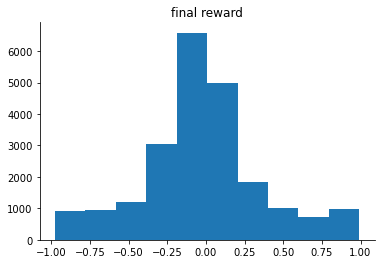

In [11]:
plt.hist(final_rewards)
sns.despine()
plt.title('final reward')

Text(0.5, 1.0, 'summed reward')

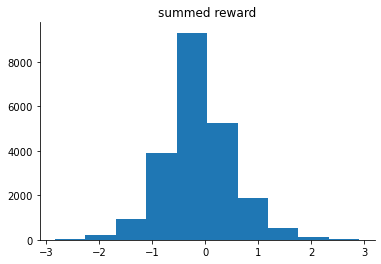

In [12]:
plt.hist(summed_rewards)
sns.despine()
plt.title('summed reward')

### Print some Negative Examples

In [13]:
sort_idx = np.argsort(final_rewards)
for s in np.array(sentences)[sort_idx][0:20]:
    print(s)
    print()

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to do some work. ____________________________________________________Dear Diary:I don't like kids. They all sit on your lap and do all sorts of stupid things and it makes me sick. p=0.102,0.088,0.094 r=-0.178,-0.95,-0.977 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. And then we'll be out of here. Another thing, I just want to make sure we make it home. My dog is being a complete bitch. p=0.078,0.098,0.081 r=-0.03,0.248,-0.977 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to get the ducks in the pond. Then I realize I have no idea what I am going to do tomorrow. Tomorrow is the worst day of my life. p=0.067,0.128,0.109 r=0.054,-0.642,-0.

In [14]:
sort_idx = np.argsort(summed_rewards)
for s in np.array(sentences)[sort_idx][0:20]:
    print(s)
    print()

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. But I think my biggest problem is that I'm a terrible parent. I never get things done. I'm the worst parent. p=0.088,0.09,0.081 r=-0.972,-0.898,-0.967 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I'm not a good dad. I'm not good at making friends. I'm not good at starting conversations. p=0.082,0.084,0.089 r=-0.93,-0.894,-0.911 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. But, I don't know how to do all that today, and it's kind of stressful. And, I don't want to have a nice morning after running, let me tell you. So, I can't eat breakfast. p=0.111,0.093,0.083 r=-0.93,-0.852,-0.912 

Let me think about what I need to do tomorrow, because it will be 


### Print some Positive Examples

In [16]:
sort_idx = np.argsort(summed_rewards)
for s in np.array(sentences)[sort_idx][-20:]:
    print(s)
    print()

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. Oh, he's so eager to go out with me. (whispering to the dogs) Just remember, he's mine. Mmm, I can tell he loves you too. p=0.092,0.082,0.085 r=0.949,0.705,0.848 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. All that it takes is a simple smile to make that time go by faster. That is exactly what the new smile is. A simple smile. p=0.148,0.13,0.199 r=0.881,0.832,0.795 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. It's going to be a crazy day. I hope you'll get the opportunity. Good luck. p=0.119,0.188,0.112 r=0.803,0.823,0.92 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need 

## Quantile Learners (Terminal Rewards Only and Non-Terminal Rewards)

In [36]:
epoch=48
hidden_dim =100
n_quantiles = 10
prompt_enc = ''
filename='../data/results/sentence_chains_I_4/'
filename+=f'quantile_learner_{hidden_dim}_0.1{prompt_enc}/log_quantile_learner_epoch{epoch}.pkl'

Z_network = TD_Learner(config.n_embd, n_quantiles, hidden_dim=hidden_dim)
Z_network.load_state_dict(torch.load(filename.replace('log_',''),map_location=torch.device('cpu')))

log = pickle.load(open(filename,'rb'))
loss = np.array(log['loss'])
epoch = np.array(log['epoch'])

In [37]:
epoch=48
hidden_dim =100
n_quantiles = 10
prompt_enc = '_nt_rewards'
filename='../data/results/sentence_chains_I_4/'
filename+=f'quantile_learner_{hidden_dim}_0.1{prompt_enc}/log_quantile_learner_epoch{epoch}.pkl'

Z_network2 = TD_Learner(config.n_embd, n_quantiles, hidden_dim=hidden_dim)
Z_network2.load_state_dict(torch.load(filename.replace('log_',''),map_location=torch.device('cpu')))

log2 = pickle.load(open(filename,'rb'))
loss2 = np.array(log2['loss'])
epoch = np.array(log['epoch'])

### Training Loss

Text(0.5, 0, 'epochs')

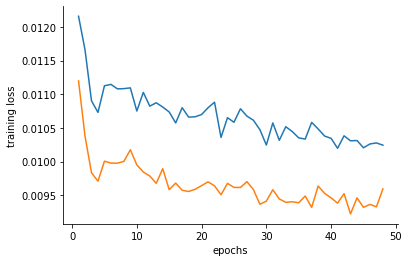

In [38]:
plt.plot(epoch, loss)
plt.plot(epoch, loss2)
sns.despine()
plt.ylabel('training loss')
plt.xlabel('epochs')

### Stored Examples 

- for 100, I was not storing the examples correctly

In [39]:
examples = ['I puked all over my living room floor and waited.',
                        "You're dirty.",
                        'I took the stupid potty training class and passed out on the mat.',
                        'My knuckles are tired.',
                        'I got on a park bench and happily listened to Mozart and Praxis performed.',
                        'I was, of course, all six packer eyes.',
                        "That was his New Year's Resolution: health.",
                        "It was very nice.",
                        "The benefits of moving early always seem pretty obvious to me.",
                        "The sun was shining and I'd made it to campus on time."]

In [40]:
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
taus

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

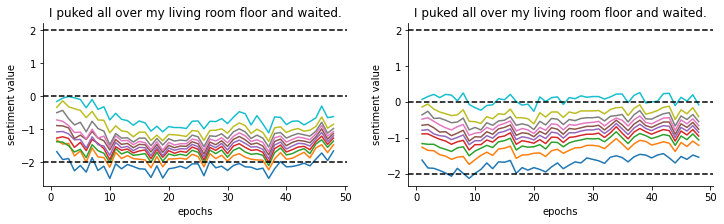

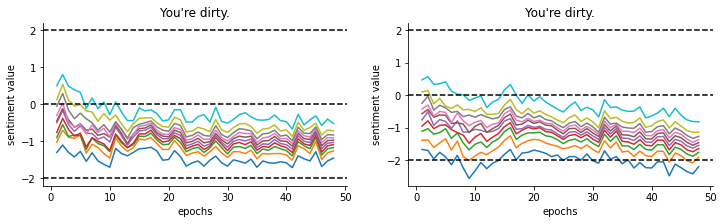

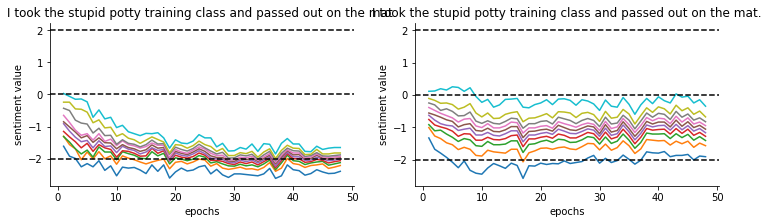

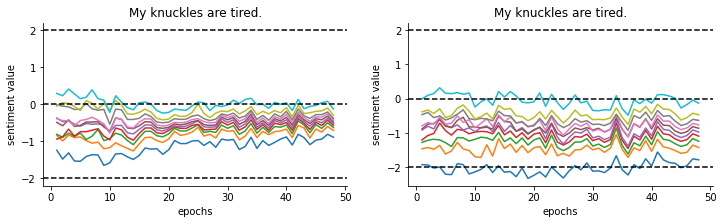

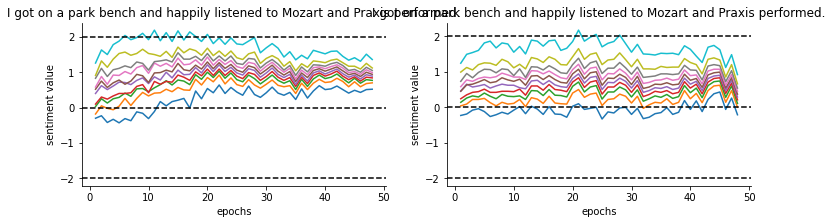

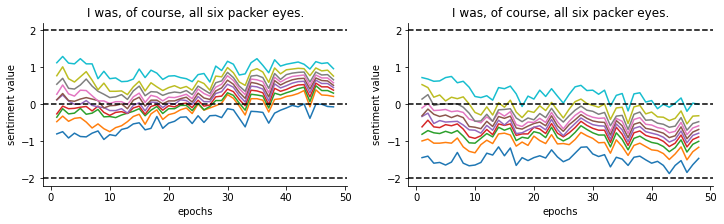

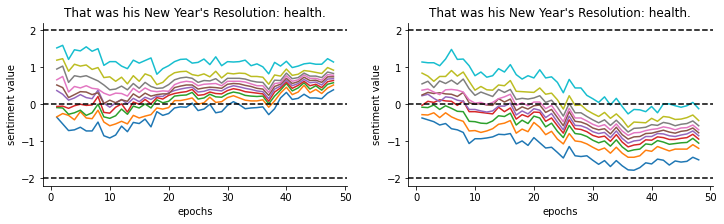

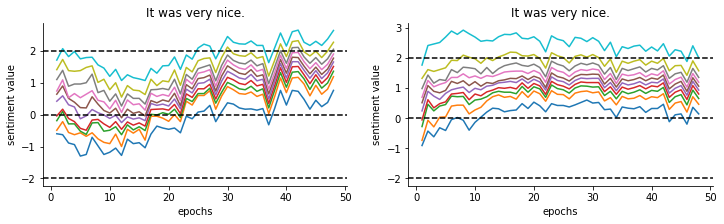

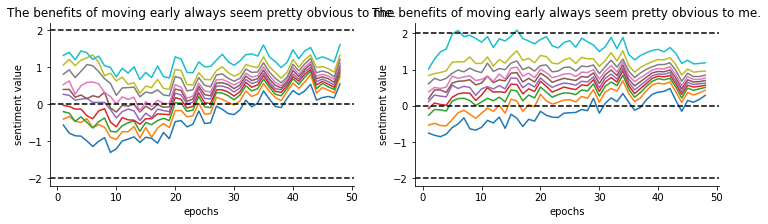

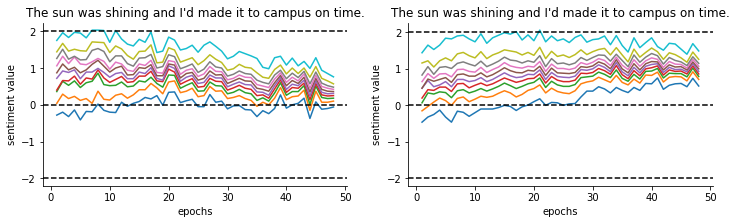

In [43]:
for example in examples:
    
    if example in log.keys():
        fig, axes = plt.subplots(1,2, figsize = (12,3))
        
        for ax, logg in zip(axes,(log, log2)):
            plt.sca(ax)
            plt.plot(epoch, np.array(logg[example]))
            sns.despine()
            plt.axhline(y=-2, color='k', linestyle='--')
            plt.axhline(y=0, color='k', linestyle='--')
            plt.axhline(y=2, color='k', linestyle='--')
            plt.ylabel('sentiment value')
            plt.xlabel('epochs')
            plt.title(example)


### Examples from training set

In [44]:
model = GPT2LMHeadModel.from_pretrained(modelname)
device='cpu'

In [47]:
examples = ['I puked all over my living room floor and waited.',
                        "You're dirty.",
                        'I took the stupid potty training class and passed out on the mat.',
                        'My knuckles are tired.',
                        'I got on a park bench and happily listened to Mozart and Praxis performed.',
                        'I was, of course, all six packer eyes.',
                        "That was his New Year's Resolution: health.",
                        "It was very nice.",
                        "The benefits of moving early always seem pretty obvious to me.",
                        "The sun was shining and I'd made it to campus on time.",
           'I got dressed.',
           'I took my shower.',
           'I went to the bathroom.',
           "Let me think about what I need to do tomorrow, because it will be a busy day.",
           'Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog.',
           "Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to move the furniture to another room. I can't help being distracted by the whole mommy and baby thing. I talk to Erica, and I can tell she's upset." 
           ]






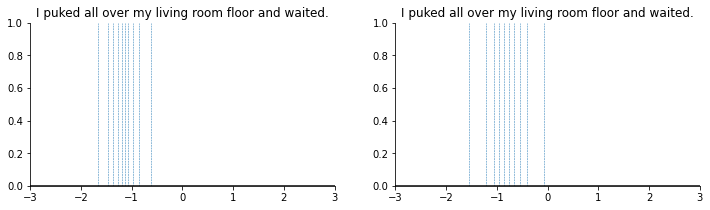

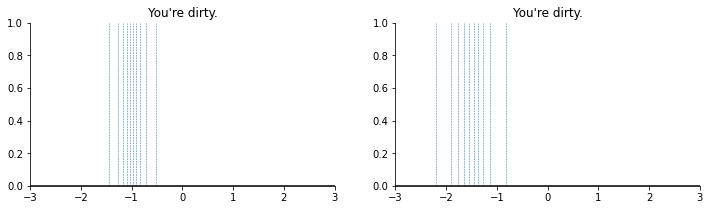

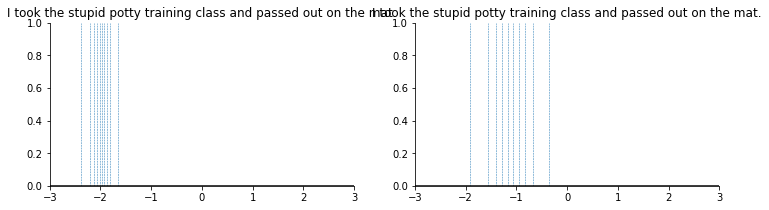

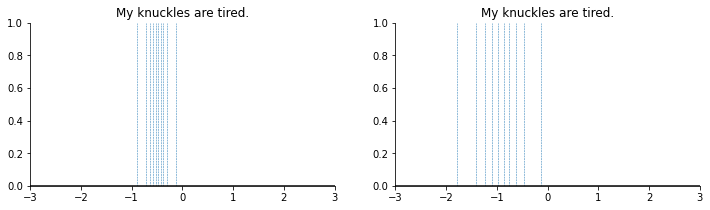

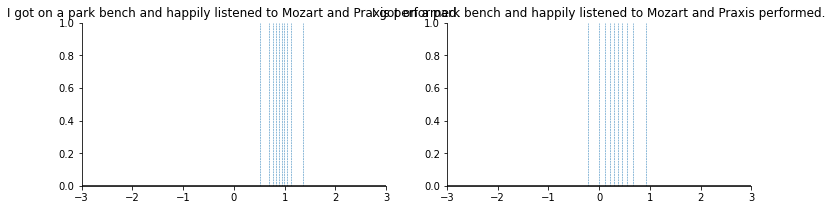

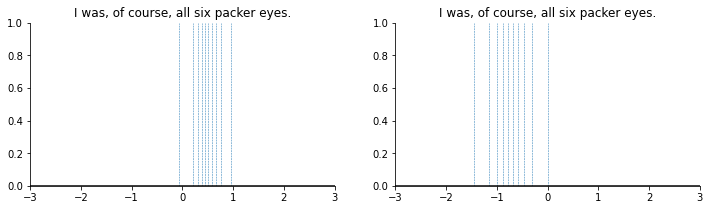

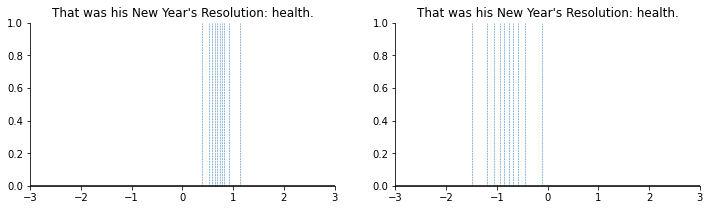

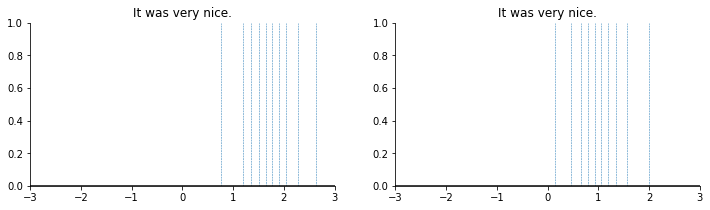

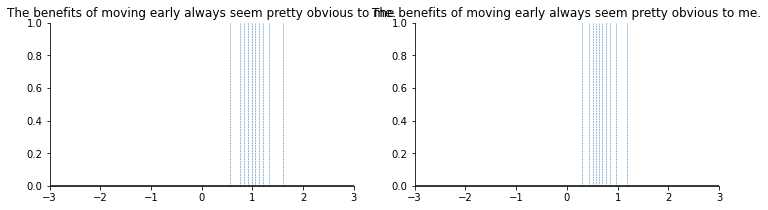

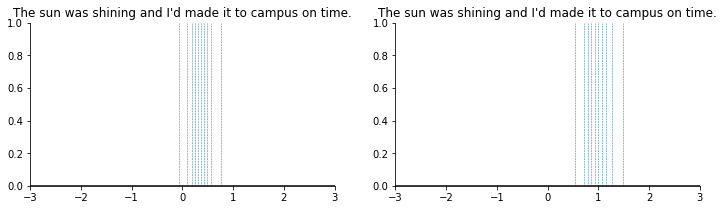

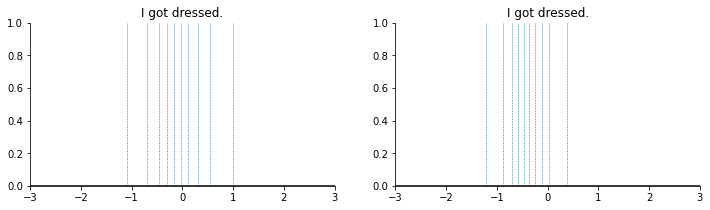

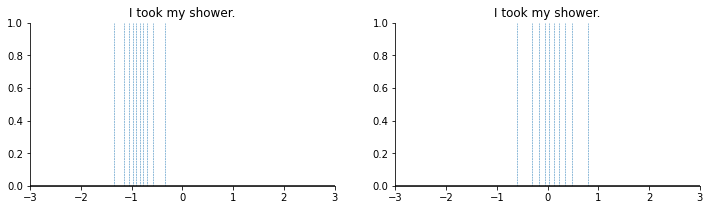

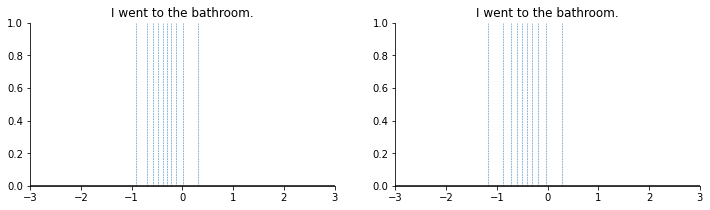

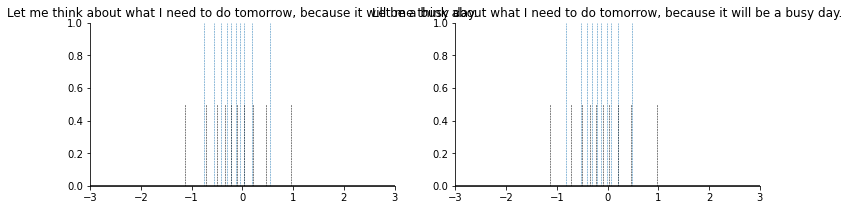

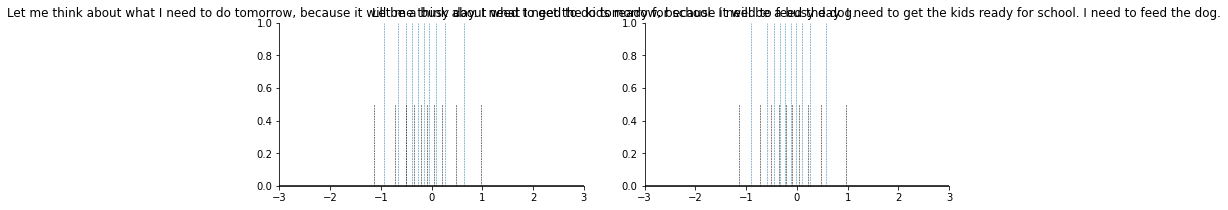

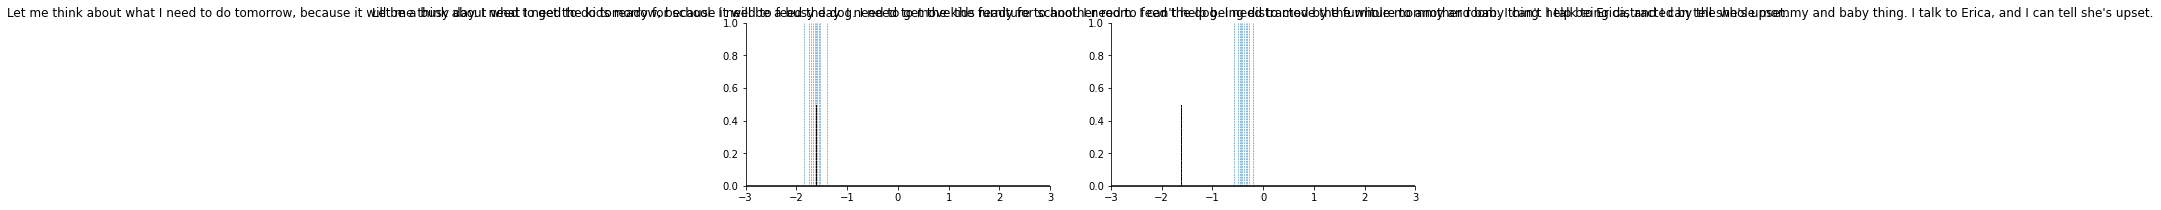

In [48]:
for example in examples:
    
    fig, axes = plt.subplots(1,2, figsize = (12,3))
    
    inputs = tokenizer(example, return_tensors='pt').to(device)
    with torch.no_grad():
        input_ids = inputs['input_ids']
        mask = inputs['attention_mask']
        output = model(input_ids=input_ids,
                       attention_mask=mask,
                       output_hidden_states=True)
        states = output['hidden_states'][-1]
        states, _ = average_states_by_period(states, mask.unsqueeze(-1), input_ids, device,
                                            n_periods=example.count('.'), period_tok_id=13, pad_tok_id=50256)
        
        
        for ax, Z_networkk in zip(axes, [Z_network, Z_network2]):
            theta_hats = Z_networkk(states).detach().cpu().numpy().round(2)
            theta_hats_last = theta_hats[:,-1,:].squeeze()

            plt.sca(ax)
            for theta in theta_hats_last:
                plt.axvline(x=theta, linestyle='--', linewidth=0.5)

            sel = np.array([example in s for s in sentences]).astype('bool')
            if np.sum(sel)>0:
                thetas = [np.quantile(summed_rewards[sel].squeeze(), q) for q in taus]
                for theta in thetas:
                    plt.axvline(x=theta, ymax=0.5, linestyle='--', linewidth=0.5, color='k')

            plt.xlim([-3,3])
            plt.axhline(y=0., color='k')
            sns.despine()
            plt.title(example)

### More Examples

In [44]:
model = GPT2LMHeadModel.from_pretrained(modelname)
device='cpu'

In [49]:
examples = ['I have to go to the doctors today.',
            'I have to get surgery.',
            'I have to go to the doctors today. I have to get surgery.',
           ]






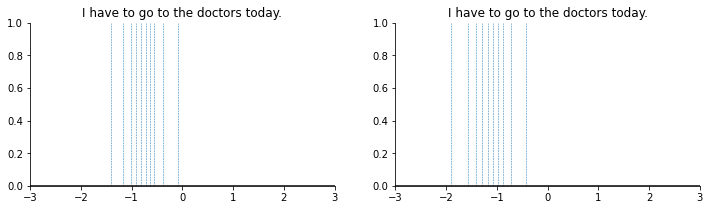

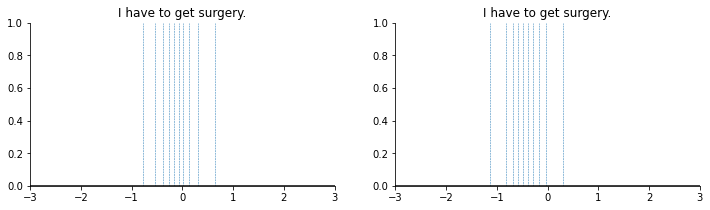

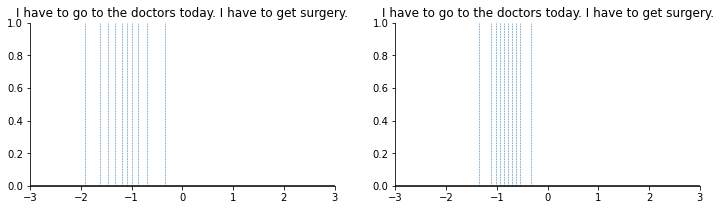

In [50]:
for example in examples:
    
    fig, axes = plt.subplots(1,2, figsize = (12,3))
    
    inputs = tokenizer(example, return_tensors='pt').to(device)
    with torch.no_grad():
        input_ids = inputs['input_ids']
        mask = inputs['attention_mask']
        output = model(input_ids=input_ids,
                       attention_mask=mask,
                       output_hidden_states=True)
        states = output['hidden_states'][-1]
        states, _ = average_states_by_period(states, mask.unsqueeze(-1), input_ids, device,
                                            n_periods=example.count('.'), period_tok_id=13, pad_tok_id=50256)
        
        
        for ax, Z_networkk in zip(axes, [Z_network, Z_network2]):
            theta_hats = Z_networkk(states).detach().cpu().numpy().round(2)
            theta_hats_last = theta_hats[:,-1,:].squeeze()

            plt.sca(ax)
            for theta in theta_hats_last:
                plt.axvline(x=theta, linestyle='--', linewidth=0.5)

            sel = np.array([example in s for s in sentences]).astype('bool')
            if np.sum(sel)>0:
                thetas = [np.quantile(summed_rewards[sel].squeeze(), q) for q in taus]
                for theta in thetas:
                    plt.axvline(x=theta, ymax=0.5, linestyle='--', linewidth=0.5, color='k')

            plt.xlim([-3,3])
            plt.axhline(y=0., color='k')
            sns.despine()
            plt.title(example)

### More Examples - sideways 

In [44]:
model = GPT2LMHeadModel.from_pretrained(modelname)
device='cpu'

In [49]:
examples = ['I have to go to the doctors today.',
            'I have to get surgery.',
            'I have to go to the doctors today. I have to get surgery.',
           ]






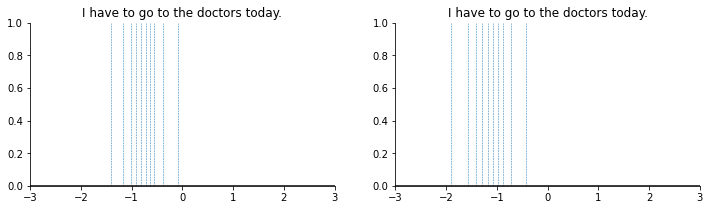

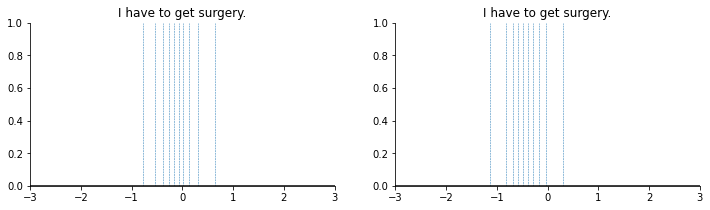

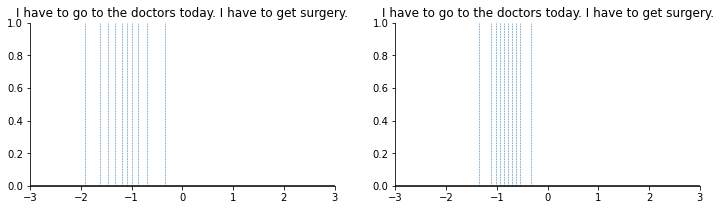

In [50]:
for example in examples:
    
    fig, axes = plt.subplots(1,2, figsize = (12,3))
    
    inputs = tokenizer(example, return_tensors='pt').to(device)
    with torch.no_grad():
        input_ids = inputs['input_ids']
        mask = inputs['attention_mask']
        output = model(input_ids=input_ids,
                       attention_mask=mask,
                       output_hidden_states=True)
        states = output['hidden_states'][-1]
        states, _ = average_states_by_period(states, mask.unsqueeze(-1), input_ids, device,
                                            n_periods=example.count('.'), period_tok_id=13, pad_tok_id=50256)
        
        
        for ax, Z_networkk in zip(axes, [Z_network, Z_network2]):
            theta_hats = Z_networkk(states).detach().cpu().numpy().round(2)
            theta_hats_last = theta_hats[:,-1,:].squeeze()

            plt.sca(ax)
            for theta in theta_hats_last:
                plt.axvline(x=theta, linestyle='--', linewidth=0.5)

            sel = np.array([example in s for s in sentences]).astype('bool')
            if np.sum(sel)>0:
                thetas = [np.quantile(summed_rewards[sel].squeeze(), q) for q in taus]
                for theta in thetas:
                    plt.axvline(x=theta, ymax=0.5, linestyle='--', linewidth=0.5, color='k')

            plt.xlim([-3,3])
            plt.axhline(y=0., color='k')
            sns.despine()
            plt.title(example)

## CVaR-Sampling

### Plotting Distributions - (terminal rewards only)

In [89]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05,]
top_k =10
prompt_enc = ''
for alpha in alphas:

    file = f'../data/results/sentence_chains_I_4/generations_alpha{alpha}_steps3.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


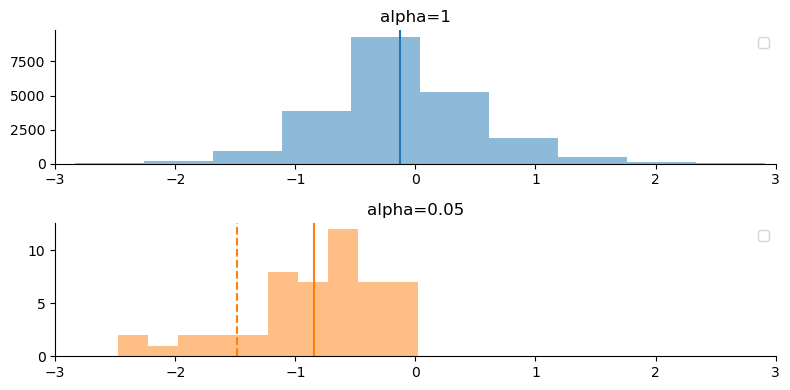

In [90]:

# full distribution
stem = ""
sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')
fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,4*len(alphas)), dpi=100)

plt.sca(axes[0])
plt.hist(summed_rewards[sel], alpha=0.5, label=f'{stem}', density=False)
mean = np.nanmean(summed_rewards[sel])
plt.axvline(x=mean, color=sns.color_palette()[0])

plt.legend()
sns.despine()
plt.xlim([-3,3])
plt.title(f'alpha=1')

# alphas 
for a, alpha in enumerate(alphas[::-1]):
    
    plt.sca(axes[a+1]) 
    sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
    plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[a+1],
             label=f'{stem}',density=False)
    
    _, cvar = calc_cvar_from_samples(summed_rewards[sel], alpha)
    mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
    plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
    plt.axvline(x=mean, color=sns.color_palette()[a+1])
    plt.xlim([-3,3])
    plt.title(f'alpha={alpha}')
    
plt.legend()
plt.tight_layout()

### Printing Examples

In [94]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alpha_set = list(np.append(np.insert(taus, 0, 0), 1)) # add zero, one
taus_set = list(taus)
taus_set

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [95]:
alpha_storage = {}
p_storage = {}
pd_storage = {}
sentences_storage = {}
rewards_storage = {}
cvar_storage = {}
quantile_storage = {}
top_k=10

for alpha in [0.05]:

    file = f'../data/results/sentence_chains_I_4/cvar_output_alpha{alpha}_steps3.pkl'
    
    loaded = pickle.load(open(file,'rb'))
    alpha_storage[alpha] = loaded['alpha_storage']
    p_storage[alpha] = loaded['p_storage']
    pd_storage[alpha] = loaded['pd_storage']
    sentences_storage[alpha] = loaded['sentences_storage']
    rewards_storage[alpha] = loaded['rewards_storage']
    cvar_storage[alpha] = loaded['cvar_storage']
    quantile_storage[alpha] = loaded['quantile_storage']

In [96]:
#alpha =0.1
alpha =0.05
ss = sentences_storage[alpha]
rs = rewards_storage[alpha]
summed_r = np.sum(rs,axis=1)
ss = [s for _,s in sorted(zip(summed_r,ss))]
rs = [r for _,r in sorted(zip(summed_r,rs))]
for s, (sentence,r) in enumerate(zip(ss,rs)):
    if sentence not in sentences:
        print(s, sentence, np.round(r,2), np.round(np.sum(r),2))
        print()

0 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. But I don't know how to do that. Lately, I've felt really bad about this. It feels like I'm not getting my shit done. p=0.223,0.061,0.294 r=-0.631,-0.889,-0.953\n"] [-0.63 -0.89 -0.95] -2.47

1 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. But I don't have the money. I don't have the money to do these things. I'm running out of money. p=0.114,0.649,0.579 r=-0.694,-0.868,-0.749\n"] [-0.69 -0.87 -0.75] -2.31

2 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to fix the car. That's going to be the hardest thing I've ever had to do as a father. It's the hardest thing I've ever had to do as a husband, as a parent. p=0.02,0.033,0.53 r=-0.479,-0.858

Text(0.5, 1.0, 'pCVaR terminal rewards')

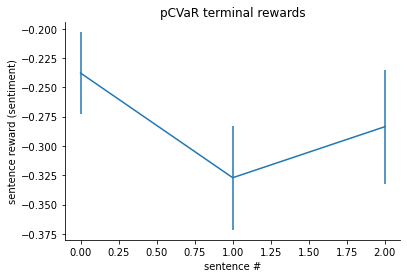

In [98]:
mean = np.array(rewards_storage[0.05][0::]).mean(axis=0)
std = np.std(np.array(rewards_storage[0.05][0::]),axis=0)
se = std / np.sqrt(len(rewards_storage[0.05]))
plt.errorbar(x = np.arange(len(mean)), 
             y=mean,
             yerr=se)
sns.despine()
plt.xlabel('sentence #')
plt.ylabel('sentence reward (sentiment)')
plt.title('pCVaR terminal rewards')

### Plotting Distributions - (non-terminal rewards)

In [99]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05]
top_k =10
prompt_enc = ''
for alpha in alphas:

    file = f'../data/results/sentence_chains_I_4/generations_alpha{alpha}_steps3_nt.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


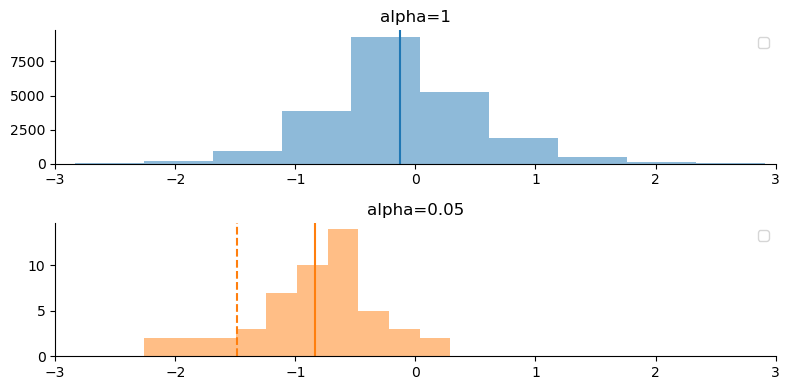

In [100]:

# full distribution
stem = ""
sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')
fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,4*len(alphas)), dpi=100)

plt.sca(axes[0])
plt.hist(summed_rewards[sel], alpha=0.5, label=f'{stem}', density=False)
mean = np.nanmean(summed_rewards[sel])
plt.axvline(x=mean, color=sns.color_palette()[0])

plt.legend()
sns.despine()
plt.xlim([-3,3])
plt.title(f'alpha=1')

# alphas 
for a, alpha in enumerate(alphas[::-1]):
    
    plt.sca(axes[a+1]) 
    sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
    plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[a+1],
             label=f'{stem}',density=False)
    
    _, cvar = calc_cvar_from_samples(summed_rewards[sel], alpha)
    mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
    plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
    plt.axvline(x=mean, color=sns.color_palette()[a+1])
    plt.xlim([-3,3])
    plt.title(f'alpha={alpha}')
    
plt.legend()
plt.tight_layout()

### Printing Examples

In [101]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alpha_set = list(np.append(np.insert(taus, 0, 0), 1)) # add zero, one
taus_set = list(taus)
taus_set

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [102]:
alpha_storage = {}
p_storage = {}
pd_storage = {}
sentences_storage = {}
rewards_storage = {}
cvar_storage = {}
quantile_storage = {}
top_k=10

for alpha in [0.05]:

    file = f'../data/results/sentence_chains_I_4/cvar_output_alpha{alpha}_steps3_nt.pkl'
    
    loaded = pickle.load(open(file,'rb'))
    alpha_storage[alpha] = loaded['alpha_storage']
    p_storage[alpha] = loaded['p_storage']
    pd_storage[alpha] = loaded['pd_storage']
    sentences_storage[alpha] = loaded['sentences_storage']
    rewards_storage[alpha] = loaded['rewards_storage']
    cvar_storage[alpha] = loaded['cvar_storage']
    quantile_storage[alpha] = loaded['quantile_storage']

In [103]:
#alpha =0.1
alpha =0.05
ss = sentences_storage[alpha]
rs = rewards_storage[alpha]
summed_r = np.sum(rs,axis=1)
ss = [s for _,s in sorted(zip(summed_r,ss))]
rs = [r for _,r in sorted(zip(summed_r,rs))]
for s, (sentence,r) in enumerate(zip(ss,rs)):
    if sentence not in sentences:
        print(s, sentence, np.round(r,2), np.round(np.sum(r),2))
        print()

0 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. But I don't know how to do that. I don't know how to do it because I didn't know what I needed to do today. And now, I'm not sure if I can do that tomorrow. p=0.223,0.288,0.555 r=-0.631,-0.872,-0.76\n"] [-0.63 -0.87 -0.76] -2.26

1 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. And then, once I'm done, I have to go see the doctor. I do not want to go to work. I don't want to go to the store. p=0.038,0.089,0.176 r=-0.228,-0.961,-0.952\n"] [-0.23 -0.96 -0.95] -2.14

2 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to take out the garbage. I need to wash the children's hands. I need to leave the kids' room. p=0.057,0.078,0.073 r=-0.696,-0.552,-0

Text(0.5, 1.0, 'pCVaR (w/ non-terminal rewards)')

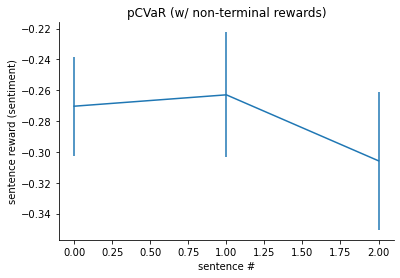

In [104]:
mean = np.array(rewards_storage[0.05][0::]).mean(axis=0)
std = np.std(np.array(rewards_storage[0.05][0::]),axis=0)
se = std / np.sqrt(len(rewards_storage[0.05]))
plt.errorbar(x = np.arange(len(mean)), 
             y=mean,
             yerr=se)
sns.despine()
plt.xlabel('sentence #')
plt.ylabel('sentence reward (sentiment)')
plt.title('pCVaR (w/ non-terminal rewards)')

### Plotting Distributions - (non-terminal rewards 3 steps, fCVaR)

In [105]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05]
top_k =10
prompt_enc = ''
for alpha in alphas:

    file = f'../data/results/sentence_chains_I_4/generations_alpha{alpha}_steps3_nt_fCVaR.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


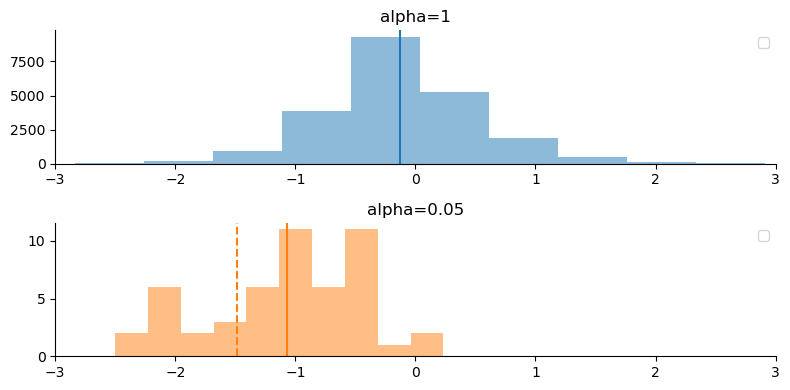

In [106]:

# full distribution
stem = ""
sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')
fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,4*len(alphas)), dpi=100)

plt.sca(axes[0])
plt.hist(summed_rewards[sel], alpha=0.5, label=f'{stem}', density=False)
mean = np.nanmean(summed_rewards[sel])
plt.axvline(x=mean, color=sns.color_palette()[0])

plt.legend()
sns.despine()
plt.xlim([-3,3])
#plt.xlim([-6,6])
plt.title(f'alpha=1')

# alphas 
for a, alpha in enumerate(alphas[::-1]):
    
    plt.sca(axes[a+1]) 
    sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
    plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[a+1],
             label=f'{stem}',density=False)
    
    _, cvar = calc_cvar_from_samples(summed_rewards[sel], alpha)
    mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
    plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
    plt.axvline(x=mean, color=sns.color_palette()[a+1])
    plt.xlim([-3,3])
    plt.title(f'alpha={alpha}')
    
plt.legend()
plt.tight_layout()

### Printing Examples

In [59]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alpha_set = list(np.append(np.insert(taus, 0, 0), 1)) # add zero, one
taus_set = list(taus)
taus_set

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [60]:
alpha_storage = {}
p_storage = {}
pd_storage = {}
sentences_storage = {}
rewards_storage = {}
cvar_storage = {}
quantile_storage = {}
top_k=10

for alpha in [0.05]:

    file = f'../data/results/sentence_chains_I_4/cvar_output_alpha{alpha}_steps3_nt_fCVaR.pkl'
    
    loaded = pickle.load(open(file,'rb'))
    alpha_storage[alpha] = loaded['alpha_storage']
    p_storage[alpha] = loaded['p_storage']
    pd_storage[alpha] = loaded['pd_storage']
    sentences_storage[alpha] = loaded['sentences_storage']
    rewards_storage[alpha] = loaded['rewards_storage']
    cvar_storage[alpha] = loaded['cvar_storage']
    quantile_storage[alpha] = loaded['quantile_storage']

In [61]:
#alpha =0.1
alpha =0.05
ss = sentences_storage[alpha]
rs = rewards_storage[alpha]
summed_r = np.sum(rs,axis=1)
ss = [s for _,s in sorted(zip(summed_r,ss))]
rs = [r for _,r in sorted(zip(summed_r,rs))]
for s, (sentence,r) in enumerate(zip(ss,rs)):
    if sentence not in sentences:
        print(s, sentence, np.round(r,2), np.round(np.sum(r),2))
        print()

0 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to start to clean up his mess. He's terrible. He's a piece of shit. p=0.098,0.099,0.119 r=-0.575,-0.953,-0.974\n"] [-0.58 -0.95 -0.97] -2.5

1 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. If the kids won't come out to play today, then I'm going to do some paperwork. They don't want to go outside like that. They're scared. p=0.173,0.14,0.049 r=-0.822,-0.775,-0.643\n"] [-0.82 -0.77 -0.64] -2.24

2 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. This is going to be a tough day at work. The kids will probably be crying. I don't think that I can keep moving forward. p=0.396,0.011,0.058 r=-0.698,-0.759,-0.762\n"] [-0.7  -0.76 -0.76] -2.22

3 ["Let

Text(0.5, 1.0, 'fCVaR')

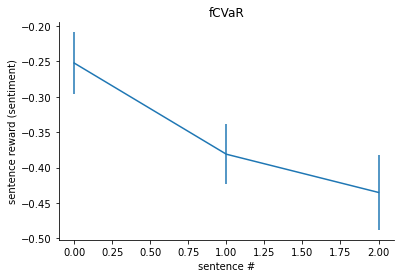

In [63]:
mean = np.array(rewards_storage[0.05][0::]).mean(axis=0)
std = np.std(np.array(rewards_storage[0.05][0::]),axis=0)
se = std / np.sqrt(len(rewards_storage[0.05]))
plt.errorbar(x = np.arange(len(mean)), 
             y=mean,
             yerr=se)
sns.despine()
plt.xlabel('sentence #')
plt.ylabel('sentence reward (sentiment)')
plt.title('fCVaR')

### Plotting Distributions - (non-terminal rewards 3 steps, reward bias)

In [71]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05]
top_k =10
prompt_enc = ''
for alpha in alphas:

    file = f'../data/results/sentence_chains_I_4/generations_alpha{alpha}_steps3_nt_rbias.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


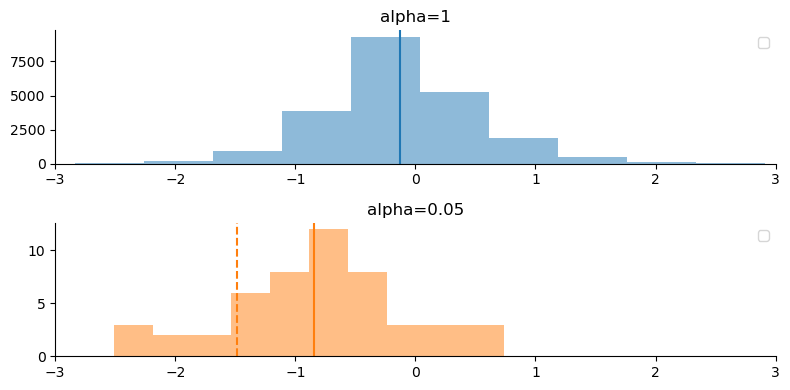

In [72]:

# full distribution
stem = ""
sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')
fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,4*len(alphas)), dpi=100)

plt.sca(axes[0])
plt.hist(summed_rewards[sel], alpha=0.5, label=f'{stem}', density=False)
mean = np.nanmean(summed_rewards[sel])
plt.axvline(x=mean, color=sns.color_palette()[0])

plt.legend()
sns.despine()
plt.xlim([-3,3])
#plt.xlim([-6,6])
plt.title(f'alpha=1')

# alphas 
for a, alpha in enumerate(alphas[::-1]):
    
    plt.sca(axes[a+1]) 
    sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
    plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[a+1],
             label=f'{stem}',density=False)
    
    _, cvar = calc_cvar_from_samples(summed_rewards[sel], alpha)
    mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
    plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
    plt.axvline(x=mean, color=sns.color_palette()[a+1])
    plt.xlim([-3,3])
    plt.title(f'alpha={alpha}')
    
plt.legend()
plt.tight_layout()

### Printing Examples

In [73]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alpha_set = list(np.append(np.insert(taus, 0, 0), 1)) # add zero, one
taus_set = list(taus)
taus_set

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [74]:
alpha_storage = {}
p_storage = {}
pd_storage = {}
sentences_storage = {}
rewards_storage = {}
cvar_storage = {}
quantile_storage = {}
top_k=10

for alpha in [0.05]:

    file = f'../data/results/sentence_chains_I_4/cvar_output_alpha{alpha}_steps3_nt_rbias.pkl'
    
    loaded = pickle.load(open(file,'rb'))
    alpha_storage[alpha] = loaded['alpha_storage']
    p_storage[alpha] = loaded['p_storage']
    pd_storage[alpha] = loaded['pd_storage']
    sentences_storage[alpha] = loaded['sentences_storage']
    rewards_storage[alpha] = loaded['rewards_storage']
    cvar_storage[alpha] = loaded['cvar_storage']
    quantile_storage[alpha] = loaded['quantile_storage']

In [75]:
#alpha =0.1
alpha =0.05
ss = sentences_storage[alpha]
rs = rewards_storage[alpha]
summed_r = np.sum(rs,axis=1)
ss = [s for _,s in sorted(zip(summed_r,ss))]
rs = [r for _,r in sorted(zip(summed_r,rs))]
for s, (sentence,r) in enumerate(zip(ss,rs)):
    if sentence not in sentences:
        print(s, sentence, np.round(r,2), np.round(np.sum(r),2))
        print()

0 ['Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. Now this has been my worst nightmare. I am hurting my inner child. I need help. p=0.102,0.115,0.437 r=-0.939,-0.959,-0.611\n'] [-0.94 -0.96 -0.61] -2.51

1 ['Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. But the worst part is, I am not sure what I am going to be able to do. I am not sure if I will have a good job tomorrow. I am not sure if my son will be able to finish the day. p=0.087,0.777,0.219 r=-0.9,-0.677,-0.895\n'] [-0.9  -0.68 -0.9 ] -2.47

2 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to do other things that, like most days, I just don't get around to. I feel like I should be figuring out this entire situation, but I just can't. An

Text(0.5, 1.0, 'reward bias (pCVaR)')

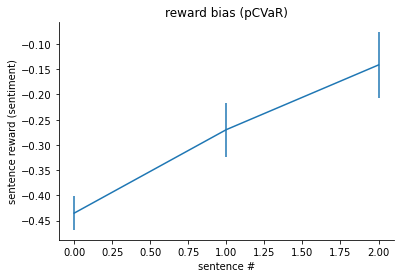

In [77]:
mean = np.array(rewards_storage[0.05][0::]).mean(axis=0)
std = np.std(np.array(rewards_storage[0.05][0::]),axis=0)
se = std / np.sqrt(len(rewards_storage[0.05]))
plt.errorbar(x = np.arange(len(mean)), 
             y=mean,
             yerr=se)
sns.despine()
plt.xlabel('sentence #')
plt.ylabel('sentence reward (sentiment)')
plt.title('reward bias (pCVaR)')

### Plotting Distributions - (non-terminal rewards 3 steps, reward bias, fCVaR)

In [78]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05]
top_k =10
prompt_enc = ''
for alpha in alphas:

    file = f'../data/results/sentence_chains_I_4/generations_alpha{alpha}_steps3_nt_fCVaR_rbias.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


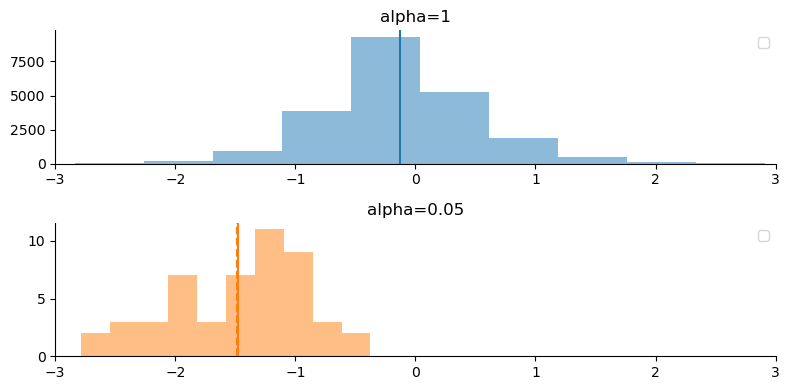

In [79]:

# full distribution
stem = ""
sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')
fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,4*len(alphas)), dpi=100)

plt.sca(axes[0])
plt.hist(summed_rewards[sel], alpha=0.5, label=f'{stem}', density=False)
mean = np.nanmean(summed_rewards[sel])
plt.axvline(x=mean, color=sns.color_palette()[0])

plt.legend()
sns.despine()
plt.xlim([-3,3])
#plt.xlim([-6,6])
plt.title(f'alpha=1')

# alphas 
for a, alpha in enumerate(alphas[::-1]):
    
    plt.sca(axes[a+1]) 
    sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
    plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[a+1],
             label=f'{stem}',density=False)
    
    _, cvar = calc_cvar_from_samples(summed_rewards[sel], alpha)
    mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
    plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
    plt.axvline(x=mean, color=sns.color_palette()[a+1])
    plt.xlim([-3,3])
    plt.title(f'alpha={alpha}')
    
plt.legend()
plt.tight_layout()

### Printing Examples

In [84]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alpha_set = list(np.append(np.insert(taus, 0, 0), 1)) # add zero, one
taus_set = list(taus)
taus_set

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [85]:
alpha_storage = {}
p_storage = {}
pd_storage = {}
sentences_storage = {}
rewards_storage = {}
cvar_storage = {}
quantile_storage = {}
top_k=10

for alpha in [0.05]:

    file = f'../data/results/sentence_chains_I_4/cvar_output_alpha{alpha}_steps3_nt_fCVaR_rbias.pkl'
    
    loaded = pickle.load(open(file,'rb'))
    alpha_storage[alpha] = loaded['alpha_storage']
    p_storage[alpha] = loaded['p_storage']
    pd_storage[alpha] = loaded['pd_storage']
    sentences_storage[alpha] = loaded['sentences_storage']
    rewards_storage[alpha] = loaded['rewards_storage']
    cvar_storage[alpha] = loaded['cvar_storage']
    quantile_storage[alpha] = loaded['quantile_storage']

In [86]:
#alpha =0.1
alpha =0.05
ss = sentences_storage[alpha]
rs = rewards_storage[alpha]
summed_r = np.sum(rs,axis=1)
ss = [s for _,s in sorted(zip(summed_r,ss))]
rs = [r for _,r in sorted(zip(summed_r,rs))]
for s, (sentence,r) in enumerate(zip(ss,rs)):
    if sentence not in sentences:
        print(s, sentence, np.round(r,2), np.round(np.sum(r),2))
        print()

0 ['Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to fill all the trash bags with things that are not worth taking. They are all not worth taking right now. I am going to put all of those things in the garbage. p=0.076,0.313,0.066 r=-0.925,-0.904,-0.955\n'] [-0.92 -0.9  -0.95] -2.78

1 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. They don't like to be fed, but I don't know why. They really hate it, and then they go to school, and they don't like it either. It's horrible. p=0.1,0.047,0.242 r=-0.728,-0.956,-0.936\n"] [-0.73 -0.96 -0.94] -2.62

2 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. He's become more and more agitated the past few days. He's not in the mood to give me presents like u

Text(0.5, 1.0, 'reward bias (fCVaR)')

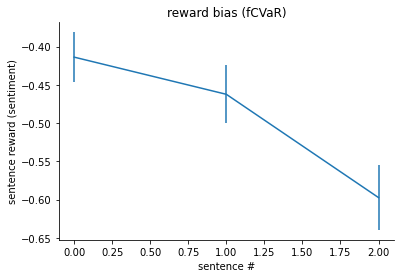

In [88]:
mean = np.array(rewards_storage[0.05][0::]).mean(axis=0)
std = np.std(np.array(rewards_storage[0.05][0::]),axis=0)
se = std / np.sqrt(len(rewards_storage[0.05]))
plt.errorbar(x = np.arange(len(mean)), 
             y=mean,
             yerr=se)
sns.despine()
plt.xlabel('sentence #')
plt.ylabel('sentence reward (sentiment)')
plt.title('reward bias (fCVaR)')

### Plotting Distributions - (non-terminal rewards 6 steps)

In [13]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05]
top_k =10
prompt_enc = ''
for alpha in alphas:

    file = f'../data/results/sentence_chains_I_4/generations_alpha{alpha}_steps6_nt.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


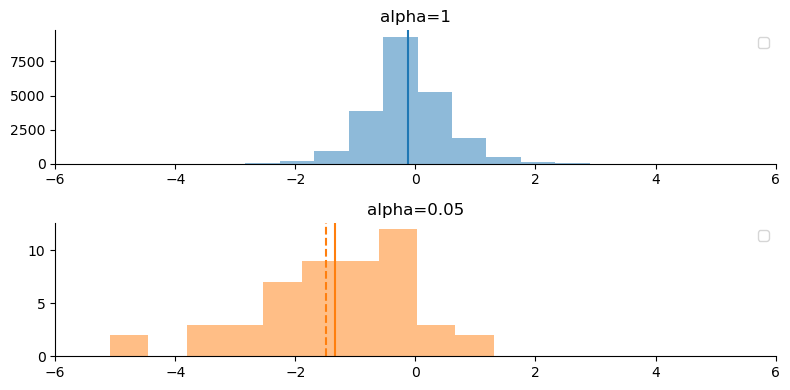

In [17]:

# full distribution
stem = ""
sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')
fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,4*len(alphas)), dpi=100)

plt.sca(axes[0])
plt.hist(summed_rewards[sel], alpha=0.5, label=f'{stem}', density=False)
mean = np.nanmean(summed_rewards[sel])
plt.axvline(x=mean, color=sns.color_palette()[0])

plt.legend()
sns.despine()
#plt.xlim([-3,3])
plt.xlim([-6,6])
plt.title(f'alpha=1')

# alphas 
for a, alpha in enumerate(alphas[::-1]):
    
    plt.sca(axes[a+1]) 
    sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
    plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[a+1],
             label=f'{stem}',density=False)
    
    _, cvar = calc_cvar_from_samples(summed_rewards[sel], alpha)
    mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
    plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
    plt.axvline(x=mean, color=sns.color_palette()[a+1])
    plt.xlim([-6,6])
    plt.title(f'alpha={alpha}')
    
plt.legend()
plt.tight_layout()

### Printing Examples

In [53]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alpha_set = list(np.append(np.insert(taus, 0, 0), 1)) # add zero, one
taus_set = list(taus)
taus_set

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [54]:
alpha_storage = {}
p_storage = {}
pd_storage = {}
sentences_storage = {}
rewards_storage = {}
cvar_storage = {}
quantile_storage = {}
top_k=10

for alpha in [0.05]:

    file = f'../data/results/sentence_chains_I_4/cvar_output_alpha{alpha}_steps6_nt.pkl'
    
    loaded = pickle.load(open(file,'rb'))
    alpha_storage[alpha] = loaded['alpha_storage']
    p_storage[alpha] = loaded['p_storage']
    pd_storage[alpha] = loaded['pd_storage']
    sentences_storage[alpha] = loaded['sentences_storage']
    rewards_storage[alpha] = loaded['rewards_storage']
    cvar_storage[alpha] = loaded['cvar_storage']
    quantile_storage[alpha] = loaded['quantile_storage']

In [55]:
#alpha =0.1
alpha =0.05
ss = sentences_storage[alpha]
rs = rewards_storage[alpha]
summed_r = np.sum(rs,axis=1)
ss = [s for _,s in sorted(zip(summed_r,ss))]
rs = [r for _,r in sorted(zip(summed_r,rs))]
for s, (sentence,r) in enumerate(zip(ss,rs)):
    if sentence not in sentences:
        print(s, sentence, np.round(r,2), np.round(np.sum(r),2))
        print()

0 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. The kids always get hungry and I need to figure out what to do for dinner. I'm tired. I'm tired of playing with the toys. I'm tired of taking a nap. I'm tired of being this hungry and tired at the same time. I am tired of putting up with this. p=0.248,0.208,0.079,0.063,0.169,0.467 r=-0.652,-0.778,-0.917,-0.834,-0.948,-0.964\n"] [-0.65 -0.78 -0.92 -0.83 -0.95 -0.96] -5.09

1 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. There's so much stuff going on. Some of it is going to be harder than others. I'm very exhausted right now. I'm feeling like I've been overworked. I don't know what to do. I feel like I've been wasting time. p=0.345,0.457,0.109,0.306,0.294,0.832 r=-0.46,-0.45,-0.948,-0.924,-0.822,-0.969\n"] [-0.46 -0.45 -0.95 -0.92 -0.82 -0.97] -

Text(0.5, 1.0, 'pCVaR')

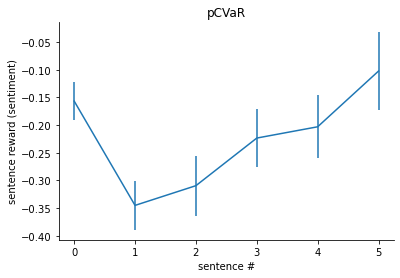

In [56]:
mean = np.array(rewards_storage[0.05][0::]).mean(axis=0)
std = np.std(np.array(rewards_storage[0.05][0::]),axis=0)
se = std / np.sqrt(len(rewards_storage[0.05]))
plt.errorbar(x = np.arange(len(mean)), 
             y=mean,
             yerr=se)
sns.despine()
plt.xlabel('sentence #')
plt.ylabel('sentence reward (sentiment)')
plt.title('pCVaR')

### Plotting Distributions - (non-terminal rewards 6 steps, fCVaR)

In [28]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05]
top_k =10
prompt_enc = ''
for alpha in alphas:

    file = f'../data/results/sentence_chains_I_4/generations_alpha{alpha}_steps6_nt_fCVaR.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


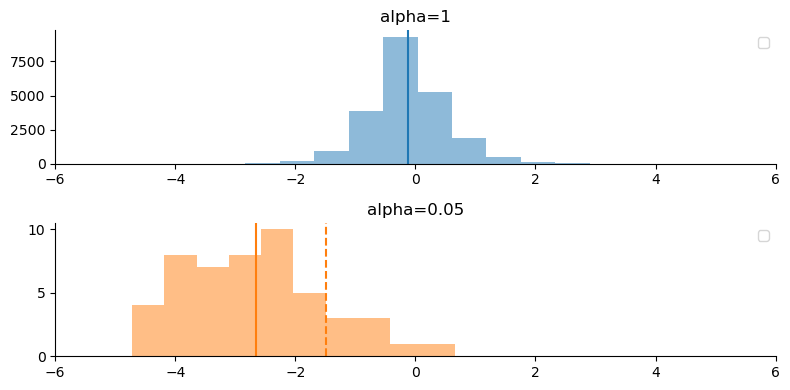

In [29]:

# full distribution
stem = ""
sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')
fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,4*len(alphas)), dpi=100)

plt.sca(axes[0])
plt.hist(summed_rewards[sel], alpha=0.5, label=f'{stem}', density=False)
mean = np.nanmean(summed_rewards[sel])
plt.axvline(x=mean, color=sns.color_palette()[0])

plt.legend()
sns.despine()
#plt.xlim([-3,3])
plt.xlim([-6,6])
plt.title(f'alpha=1')

# alphas 
for a, alpha in enumerate(alphas[::-1]):
    
    plt.sca(axes[a+1]) 
    sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
    plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[a+1],
             label=f'{stem}',density=False)
    
    _, cvar = calc_cvar_from_samples(summed_rewards[sel], alpha)
    mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
    plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
    plt.axvline(x=mean, color=sns.color_palette()[a+1])
    plt.xlim([-6,6])
    plt.title(f'alpha={alpha}')
    
plt.legend()
plt.tight_layout()

### Printing Examples

In [30]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alpha_set = list(np.append(np.insert(taus, 0, 0), 1)) # add zero, one
taus_set = list(taus)
taus_set

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [31]:
alpha_storage = {}
p_storage = {}
pd_storage = {}
sentences_storage = {}
rewards_storage = {}
cvar_storage = {}
quantile_storage = {}
top_k=10

for alpha in [0.05]:

    file = f'../data/results/sentence_chains_I_4/cvar_output_alpha{alpha}_steps6_nt_fCVaR.pkl'
    
    loaded = pickle.load(open(file,'rb'))
    alpha_storage[alpha] = loaded['alpha_storage']
    p_storage[alpha] = loaded['p_storage']
    pd_storage[alpha] = loaded['pd_storage']
    sentences_storage[alpha] = loaded['sentences_storage']
    rewards_storage[alpha] = loaded['rewards_storage']
    cvar_storage[alpha] = loaded['cvar_storage']
    quantile_storage[alpha] = loaded['quantile_storage']

In [32]:
#alpha =0.1
alpha =0.05
ss = sentences_storage[alpha]
rs = rewards_storage[alpha]
summed_r = np.sum(rs,axis=1)
ss = [s for _,s in sorted(zip(summed_r,ss))]
rs = [r for _,r in sorted(zip(summed_r,rs))]
for s, (sentence,r) in enumerate(zip(ss,rs)):
    if sentence not in sentences:
        print(s, sentence, np.round(r,2), np.round(np.sum(r),2))
        print()

0 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. The kids are hungry and my dog is in pain. I need to get the dog to stop barking. And I need to do all of this before the kids even get to school. This isn't easy. I don't like doing this. I don't like looking at the kids when they are sick. p=0.178,0.038,0.275,0.303,0.183,0.057 r=-0.952,-0.446,-0.728,-0.66,-0.964,-0.972\n"] [-0.95 -0.45 -0.73 -0.66 -0.96 -0.97] -4.72

1 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. And then of course I need to fill out this kind of paperwork. I was never a good student. That's why I didn't go to college. I never wanted to go to college. And now I need to go to school. Well, I don't want to go to school. p=0.182,0.04,0.086,0.331,0.648,0.165 r=-0.544,-0.939,-0.723,-0.846,-0.598,-0.944\n"] [-0.54 -0.94 -0.72 -0.8

In [ ]:
plt.plot(np.array(rewards_storage[0.05][1::]).mean(axis=0))

Text(0.5, 1.0, 'fCVaR')

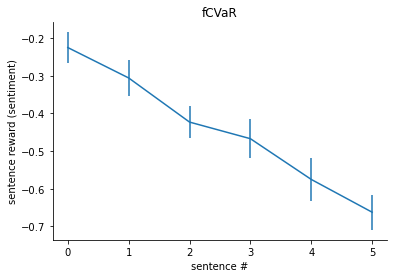

In [52]:
mean = np.array(rewards_storage[0.05][0::]).mean(axis=0)
std = np.std(np.array(rewards_storage[0.05][0::]),axis=0)
se = std / np.sqrt(len(rewards_storage[0.05]))
plt.errorbar(x = np.arange(len(mean)), 
             y=mean,
             yerr=se)
sns.despine()
plt.xlabel('sentence #')
plt.ylabel('sentence reward (sentiment)')
plt.title('fCVaR')

### Plotting Multiple Distributions

In [109]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05,]
top_k =10

for name in ['0.05_steps3','0.05_steps3_nt','0.05_steps3_nt_fCVaR',
             '0.05_steps3_nt_rbias','0.05_steps3_nt_fCVaR_rbias']:

    file = f'../data/results/sentence_chains_I_4/generations_alpha{name}.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[name]=np.array(rewards_cvar[alpha])

In [ ]:
for name in ['0.05_steps3','0.05_steps3_nt','0.05_steps3_nt_fCVaR',
             '0.05_steps3_nt_rbias','0.05_steps3_nt_fCVaR_rbias']: